In [3]:
!pip install pyspark

  Using cached py4j-0.10.9-py2.py3-none-any.whl (198 kB)
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612248 sha256=8ccc08b4c7797737c94da4eaf536aad555185a8bb3fda51f93e44efb6c87db5d
  Stored in directory: c:\users\moses\appdata\local\pip\cache\wheels\5e\34\fa\b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os
from tqdm.notebook import tqdm
from forexutils import *
from pyspark import SparkContext
from joblib import Parallel, delayed
sc = SparkContext('local[*]','reader')

In [5]:
file_pathes = [x for x in os.listdir() if x.endswith(".csv")][0:2]

In [6]:
file_pathes

['DAT_MT_EURUSD_M1_2018.csv', 'DAT_MT_EURUSD_M1_2019.csv']

In [7]:
from datetime import datetime

def parser(line, t='H1'):
    date, time, open, high, low, close, volume = line.split(',')
    date_ = datetime(*(list(map(int,date.split('.')))+list(map(int,time.split(':')))))
    h,m = list(map(int,time.split(':')))
    minutes = h*60 + m
    if t.startswith('M'):
        domin = int(t[1:])
        bin = (date_.year, date_.month,date_.day ,minutes//domin)
    if t.startswith('H'):
        domin = int(t[1:])*60
        bin = (date_.year, date_.month,date_.day ,minutes//domin)
    if t.startswith('D'):
        bin = (date_.year, date_.month,date_.day)
    if t.startswith('W'):
        bin = (date_.year, date_.isocalendar()[1])
    return bin, date_, float(open), float(high), float(low), float(close), int(volume)
data = []
for file in file_pathes:
    data = data + sc.textFile(file).map(lambda x: parser(x, 'M10')).collect()

In [8]:
df_ = pd.DataFrame(data, columns=['bin', 'datetime','open','high','low','close','volume'])

In [9]:
df = df_.groupby('bin').agg({'datetime':['first'], 'open':['first'], 'high':['max'], 'low':['min'], 'close':['last'],'volume':['sum','count']})

In [10]:
df.columns = ['datetime', 'open','high','low','close','volume','count']

In [11]:
df_.head()

,bin,datetime,open,high,low,close,volume
0,"(2018, 1, 1, 102)",2018-01-01 17:00:00,1.20037,1.20100,1.20037,1.20100,0
1,"(2018, 1, 1, 102)",2018-01-01 17:01:00,1.20083,1.20095,1.20017,1.20030,0
2,"(2018, 1, 1, 102)",2018-01-01 17:02:00,1.20035,1.20043,1.20035,1.20043,0
3,"(2018, 1, 1, 102)",2018-01-01 17:03:00,1.20041,1.20050,1.20031,1.20046,0
4,"(2018, 1, 1, 102)",2018-01-01 17:04:00,1.20049,1.20049,1.20046,1.20048,0


In [12]:
df_.tail()

,bin,datetime,open,high,low,close,volume
745132,"(2019, 12, 31, 101)",2019-12-31 16:55:00,1.12117,1.12118,1.12115,1.12118,0
745133,"(2019, 12, 31, 101)",2019-12-31 16:56:00,1.12118,1.12120,1.12115,1.12115,0
745134,"(2019, 12, 31, 101)",2019-12-31 16:57:00,1.12115,1.12115,1.12105,1.12105,0
745135,"(2019, 12, 31, 101)",2019-12-31 16:58:00,1.12105,1.12110,1.12099,1.12099,0
745136,"(2019, 12, 31, 101)",2019-12-31 16:59:00,1.12099,1.12115,1.12076,1.12076,0


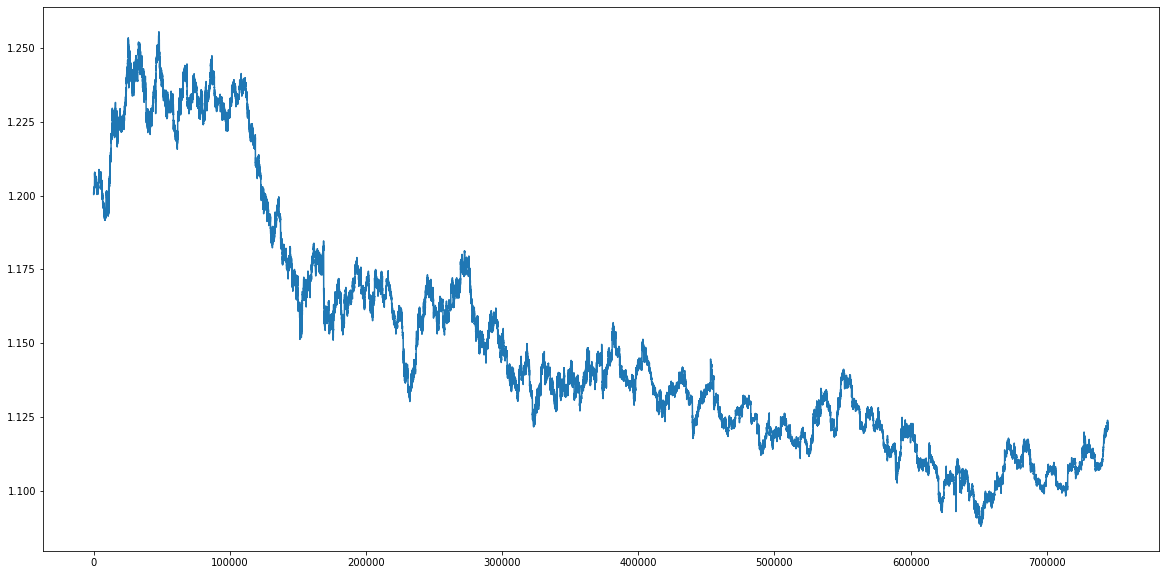

In [13]:
plt.figure(figsize=(20,10))
plt.plot(df_['close']);

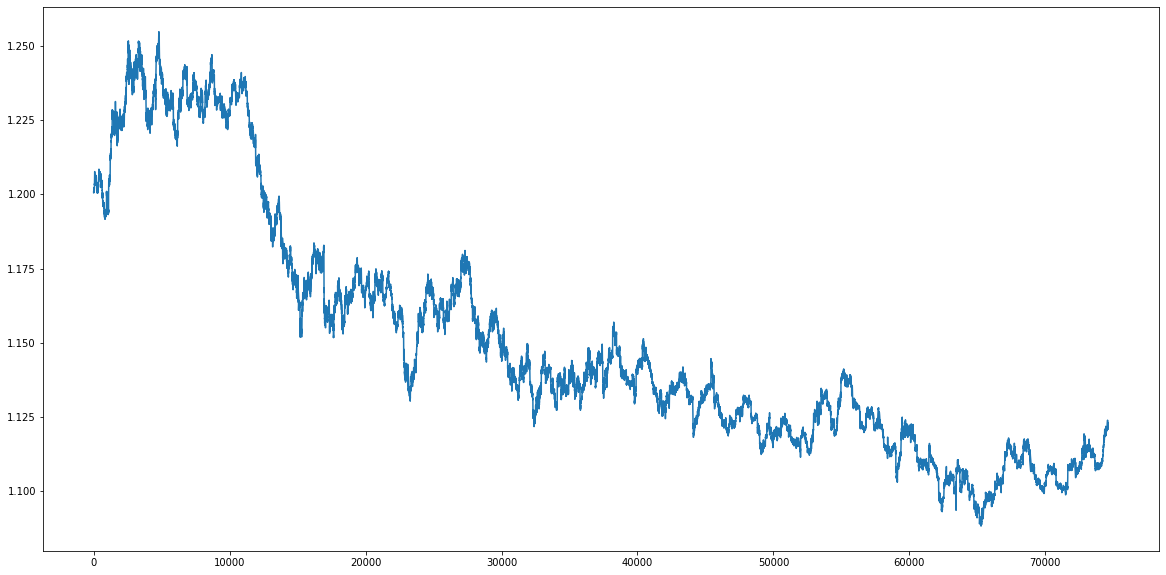

In [14]:
plt.figure(figsize=(20,10))
plt.plot(df['close'].values);

(-5e-06, 5e-06)

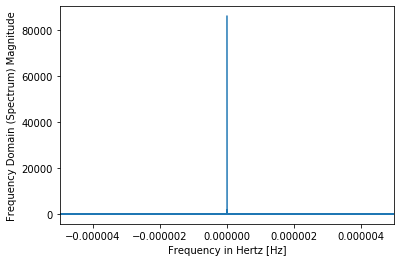

In [33]:
from scipy import fftpack
x = df['close'].values.copy()
X = fftpack.fft(x)
f_s = .00001
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.plot(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)

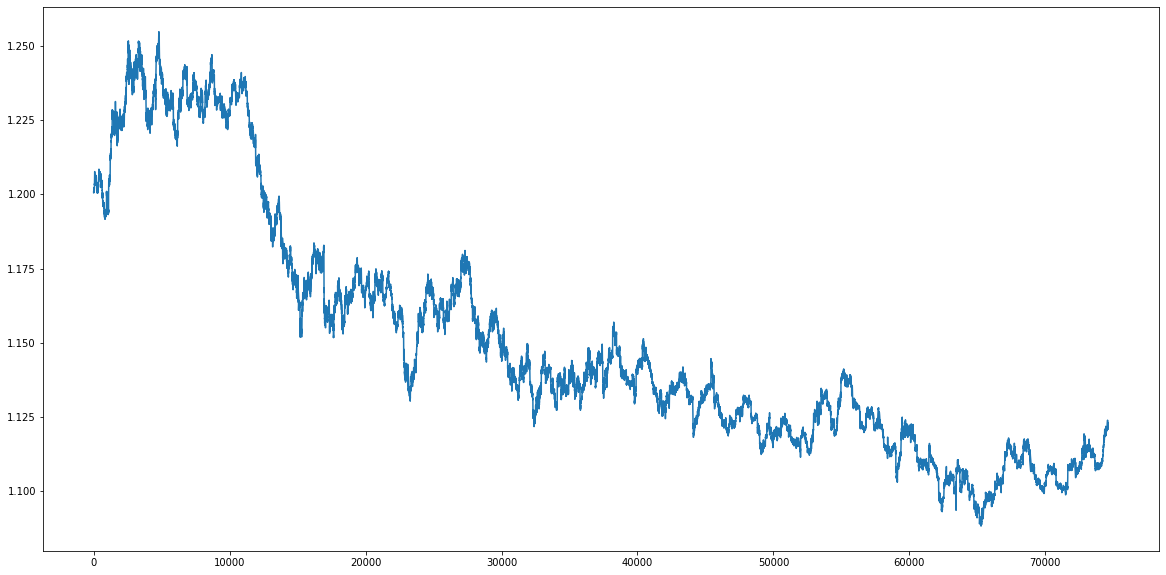

In [16]:
dfSmall = df.reset_index()
plt.figure(figsize=(20,10))
plt.plot(dfSmall['close'].values);

In [17]:
dfSmall['High-Low'] = dfSmall['high'] - dfSmall['low']
dfSmall['Close-Low'] = np.abs(dfSmall['close'].values - dfSmall['low'].values)
dfSmall['Close-High'] = np.abs(dfSmall['close'].values - dfSmall['high'].values)
dfSmall['TrueRange'] = np.max(np.array([dfSmall['High-Low'].values, dfSmall['Close-Low'].values, dfSmall['Close-High'].values]),axis=0)

jobs = {}
windows = [14, 24, 36, 48, 100]
for w in windows:
    jobs['MovingAverage{}OnClose'.format(w)] = delayed(Slider)(arr = dfSmall['close'].values, fun=np.mean, window=w)
    jobs['ExponentialMovingAverage{}OnClose'.format(w)] = delayed(Ema)(arr = dfSmall['close'].values, window=w)
    jobs['RSI{}OnClose'.format(w)] = delayed(Rsi)(arr = dfSmall['close'].values, window=w)
    jobs['MovingHigh{}OnHigh'.format(w)] = delayed(Slider)(arr = dfSmall['high'].values, fun = np.max, window=w)
    jobs['MovingLow{}OnLow'.format(w)] = delayed(Slider)(arr = dfSmall['low'].values, fun = np.min, window=w)
    jobs['AverageTrueRange{}'.format(w)] = delayed(Slider)(arr=dfSmall['TrueRange'].values, fun=np.mean, window=w)
    jobs['Std{}OnClose'.format(w)] = delayed(Slider)(arr = dfSmall['close'].values, fun = np.std, window=w)
    jobs['Slop{}OnClose'.format(w)] = delayed(Slider)(arr = dfSmall['close'].values, fun = Slope, window=w)

    
for w in [5, 9, 13, 17, 25, 35]:
    jobs['isHigh{}'.format(w)] = delayed(Slider)(arr = dfSmall['high'].values, fun = HIGH, window=w)
    jobs['isLow{}'.format(w)] = delayed(Slider)(arr = dfSmall['low'].values, fun = LOW, window=w)
    
results = Parallel(n_jobs=4)(jobs.values())
for i,key in enumerate(jobs.keys()):
    dfSmall[key] = results[i]
for w in windows:
    dfSmall['Kline{}Stochastic'.format(w)] = 100*(dfSmall['close'] - dfSmall['MovingLow{}OnLow'.format(w)])/(dfSmall['MovingHigh{}OnHigh'.format(w)]-dfSmall['MovingLow{}OnLow'.format(w)])
    dfSmall['Dline{}Stochastic'.format(w)] = Slider(arr = dfSmall['Kline{}Stochastic'.format(w)].values, fun = np.mean, window=3)
    dfSmall['BBUpperBand{}'.format(w)] = dfSmall['MovingAverage{}OnClose'.format(w)] + dfSmall['Std{}OnClose'.format(w)]*2
    dfSmall['BBLowerBand{}'.format(w)] = dfSmall['MovingAverage{}OnClose'.format(w)] - dfSmall['Std{}OnClose'.format(w)]*2
    for wj in windows:
        if w < wj:
            dfSmall['MACD{}{}'.format(w,wj)] = dfSmall['ExponentialMovingAverage{}OnClose'.format(w)] - dfSmall['ExponentialMovingAverage{}OnClose'.format(wj)]

In [18]:
for t in [15, 20, 25, 30 ,35]:
    dfSmall['oversold{}'.format(t)] = t
    dfSmall['overbought{}'.format(100-t)] = 100-t
jobs = {}
for w in windows:
    jobs['DlineEnterOverBought{}'.format(w)] = delayed(Compare)(arrA = dfSmall['Dline{}Stochastic'.format(w)].values, arrB = dfSmall['overbought80'].values, fun=Enter, window=2)
    jobs['DlineEnterOverSold{}'.format(w)] = delayed(Compare)(arrB = dfSmall['Dline{}Stochastic'.format(w)].values, arrA = dfSmall['oversold20'].values, fun=Enter, window=2)
    
    jobs['DlineEnterKline{}'.format(w)] = delayed(Compare)(arrA = dfSmall['Dline{}Stochastic'.format(w)].values, arrB = dfSmall['Kline{}Stochastic'.format(w)].values, fun=Enter, window=2)
    jobs['KlineEnterDline{}'.format(w)] = delayed(Compare)(arrB = dfSmall['Dline{}Stochastic'.format(w)].values, arrA = dfSmall['Kline{}Stochastic'.format(w)].values, fun=Enter, window=2)
results = Parallel(n_jobs=4)(jobs.values())
for i,key in enumerate(jobs.keys()):
    dfSmall[key] = results[i]

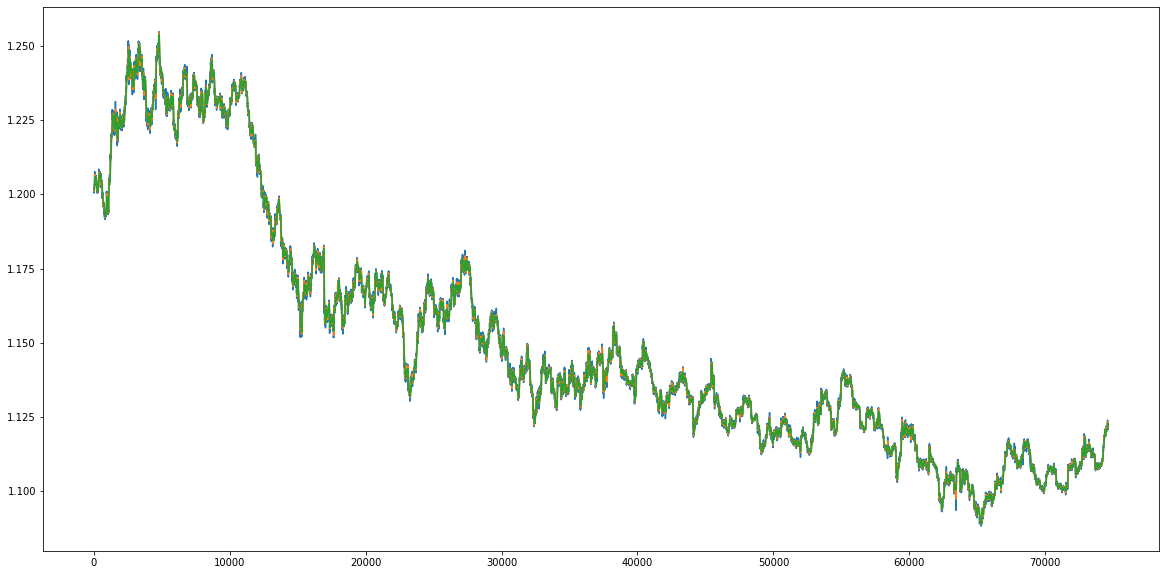

In [19]:
# dfSmall['MovingAverage14OnClose'] = Slider(arr = dfSmall['close'].values, fun=np.mean, window=14)
# dfSmall['MovingAverage36OnClose'] = Slider(arr = dfSmall['close'].values, fun=np.mean, window=36)
plt.figure(figsize=(20,10))
plt.plot(dfSmall['close'].values);
plt.plot(dfSmall['MovingAverage14OnClose'].values);
plt.plot(dfSmall['MovingAverage36OnClose'].values);

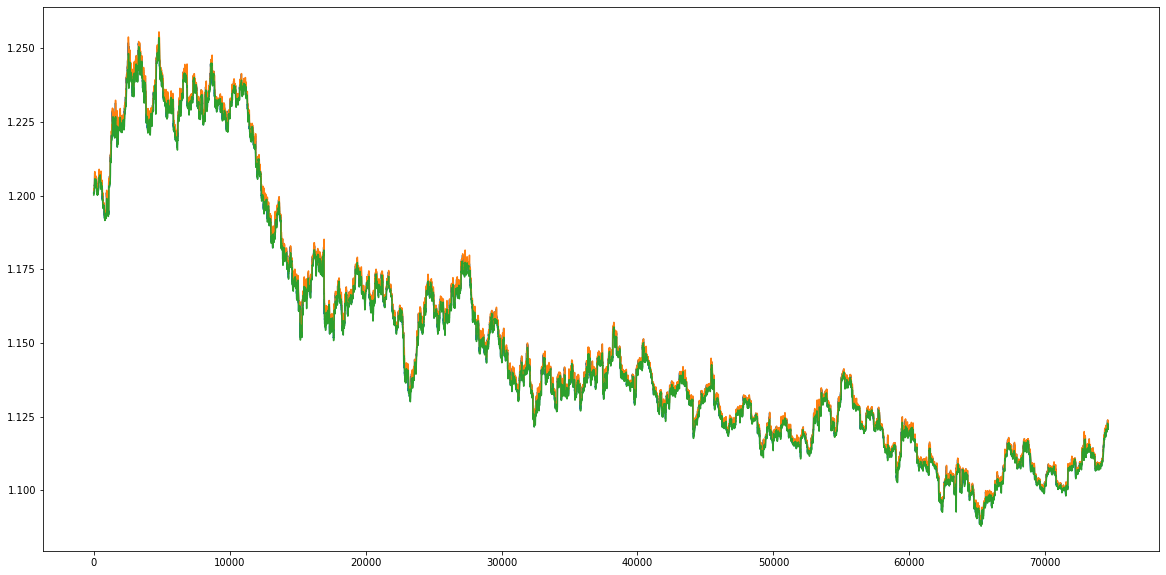

In [20]:
# dfSmall['MovingHigh14OnHigh'] = Slider(arr = dfSmall['high'].values, fun = np.max, window=14)
# dfSmall['MovingLow14OnLow'] = Slider(arr = dfSmall['low'].values, fun = np.min, window=14)
plt.figure(figsize=(20,10))
plt.plot(dfSmall['close'].values);
plt.plot(dfSmall['MovingHigh14OnHigh'].values);
plt.plot(dfSmall['MovingLow14OnLow'].values);

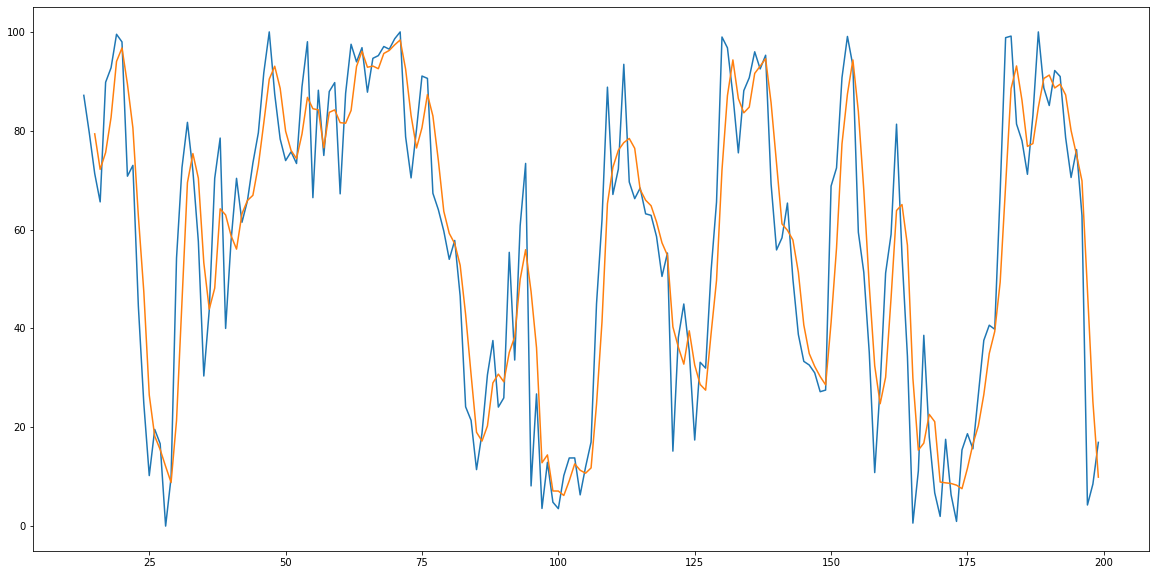

In [21]:
plt.figure(figsize=(20,10))
plt.plot(dfSmall['Kline14Stochastic'].values[0:200]);
plt.plot(dfSmall['Dline14Stochastic'].values[0:200]);

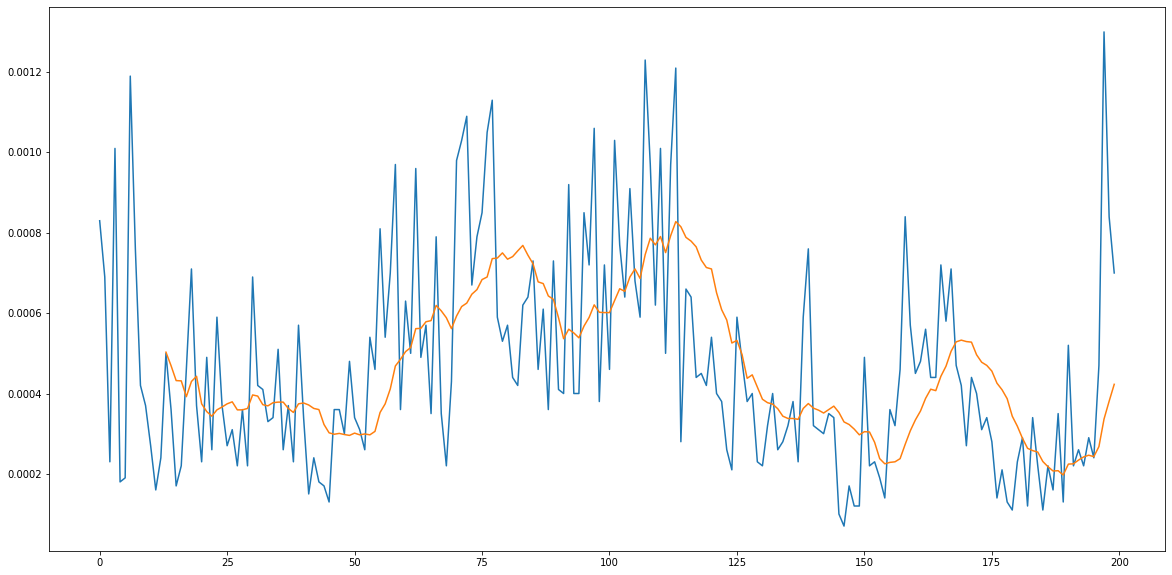

In [22]:
plt.figure(figsize=(20,10))
plt.plot(dfSmall['TrueRange'].values[0:200]);
plt.plot(dfSmall['AverageTrueRange14'].values[0:200]);

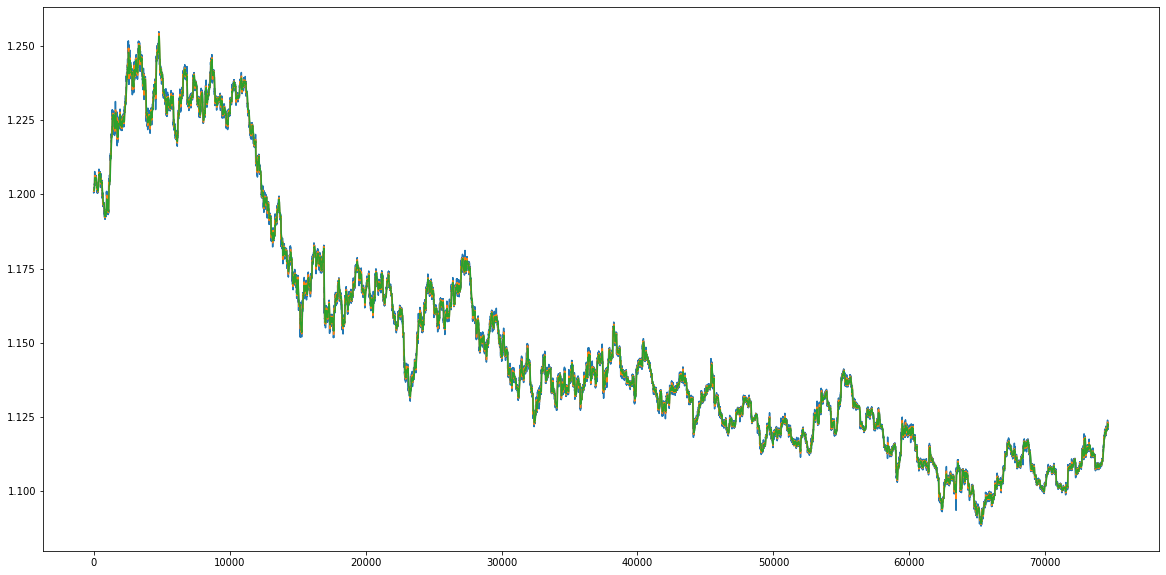

In [23]:
plt.figure(figsize=(20,10))
plt.plot(dfSmall['close'].values);
plt.plot(dfSmall['ExponentialMovingAverage14OnClose'].values);
plt.plot(dfSmall['ExponentialMovingAverage36OnClose'].values);

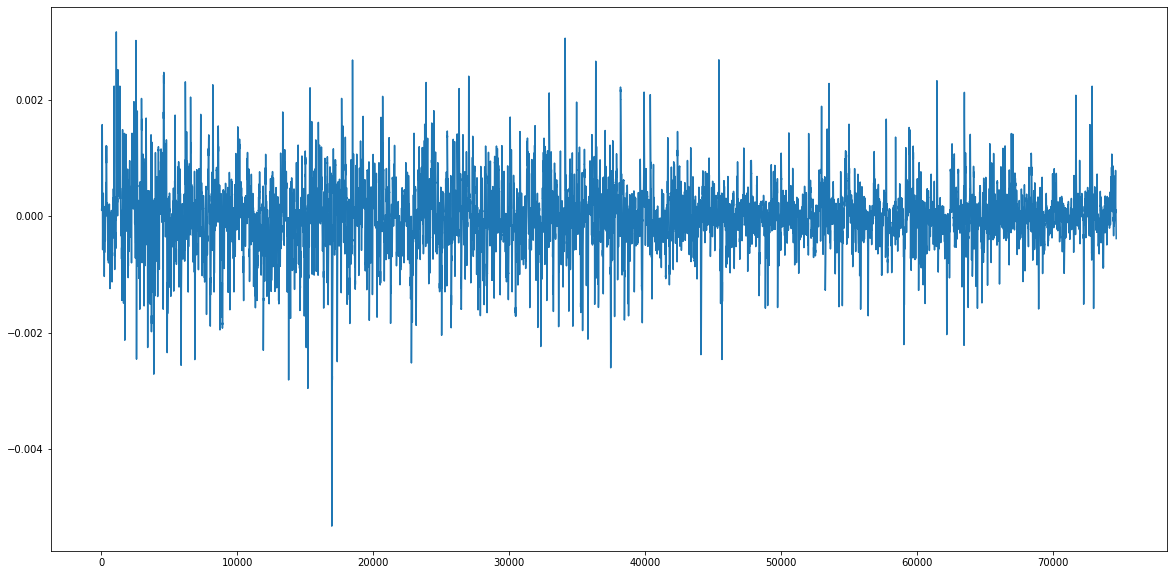

In [24]:
plt.figure(figsize=(20,10))
plt.plot(dfSmall['MACD1436'].values);

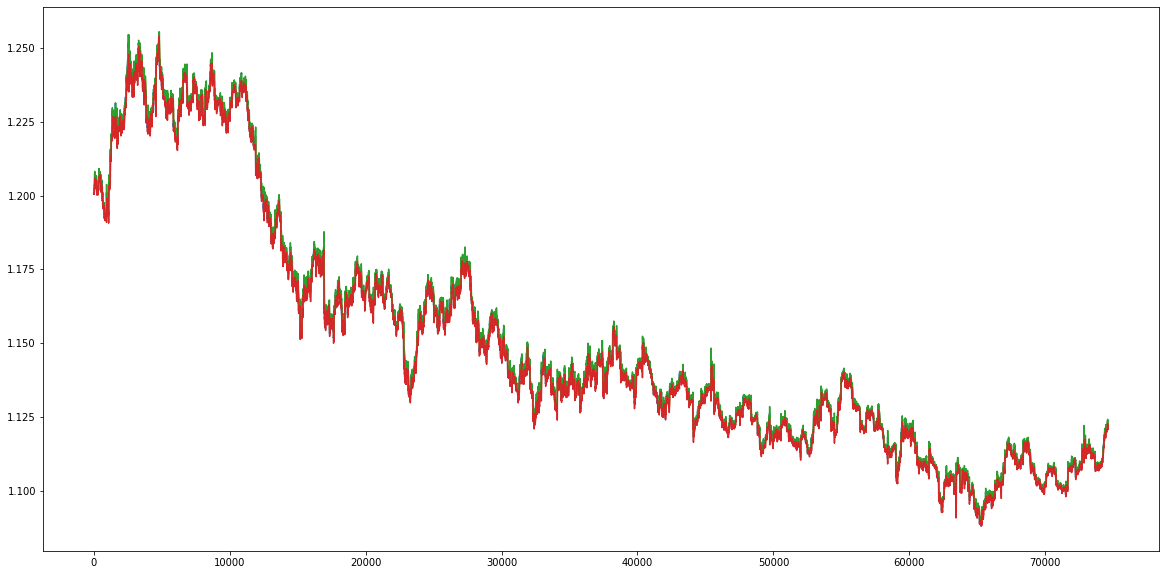

In [25]:
plt.figure(figsize=(20,10))
plt.plot(dfSmall['close'].values);
plt.plot(dfSmall['MovingAverage14OnClose'].values);
plt.plot(dfSmall['BBUpperBand14'].values);
plt.plot(dfSmall['BBLowerBand14'].values);

In [42]:
def getLabel(df, target, bigLoss, longWin):
    close_ = df['close'].values
    open_ = df['open'].values
    high_ = df['high'].values
    low_ = df['low'].values
    n = len(close_)
    label = []
    for i in range(n):
        labelLong = None
        labelShort = None
        if (i + longWin) < n:
            for j in range(i + 1, i + longWin):
                if (high_[j] > (close_[i] + target)) & (labelLong == None):
                    labelLong = target
                if (low_[j] < (close_[i] - bigLoss)) & (labelLong == None):
                    labelLong = -bigLoss
                if (low_[j] < (close_[i] - target)) & (labelShort == None):
                    labelShort = target
                if (high_[j] > (close_[i] + bigLoss)) & (labelShort == None):
                    labelShort = -bigLoss
            if labelLong == None:
                labelLong = (close_[j] - close_[i])
            if labelShort == None:
                labelShort = -(close_[j] - close_[i])
        else:
            labelLong = 0
            labelShort = 0
        label.append([labelLong, labelShort])
    return label        

In [43]:
x = getLabel(df, .003, .02, longWin=300)

In [44]:
x = np.array(x)

In [50]:
y = x

In [46]:
list(x)

[array([ 0.003  , -0.00013]),
 array([ 3.e-03, -2.e-05]),
 array([0.003  , 0.00012]),
 array([0.003  , 0.00071]),
 array([0.003  , 0.00073]),
 array([0.003  , 0.00059]),
 array([ 3.e-03, -7.e-05]),
 array([0.003  , 0.00048]),
 array([0.003 , 0.0005]),
 array([0.003 , 0.0005]),
 array([0.003  , 0.00036]),
 array([0.003  , 0.00037]),
 array([0.003 , 0.0004]),
 array([0.003  , 0.00053]),
 array([ 0.003, -0.   ]),
 array([ 0.003  , -0.00041]),
 array([ 0.003  , -0.00044]),
 array([ 3.e-03, -7.e-05]),
 array([0.003  , 0.00035]),
 array([0.003  , 0.00076]),
 array([0.003  , 0.00099]),
 array([0.003  , 0.00056]),
 array([0.003  , 0.00038]),
 array([3.e-03, 1.e-05]),
 array([ 0.003  , -0.00016]),
 array([ 0.003  , -0.00071]),
 array([ 0.003  , -0.00042]),
 array([ 0.003  , -0.00077]),
 array([ 0.003  , -0.00121]),
 array([ 0.003  , -0.00092]),
 array([ 0.003  , -0.00018]),
 array([0.003  , 0.00027]),
 array([0.003  , 0.00018]),
 array([ 3.e-03, -6.e-05]),
 array([ 0.003  , -0.00049]),
 array([

In [47]:
x.mean(axis=0)

array([-0.00033722,  0.00020682])

([array([  754.,   288.,   913.,  1811.,  3138.,  5438.,  7341.,  7907.,
          7519., 53481.]),
  array([ 1047.,   296.,   705.,  1573.,  2769.,  3814.,  5367.,  6529.,
          6743., 59747.])],
 array([-0.02  , -0.0177, -0.0154, -0.0131, -0.0108, -0.0085, -0.0062,
        -0.0039, -0.0016,  0.0007,  0.003 ]),
 <a list of 2 Lists of Patches objects>)

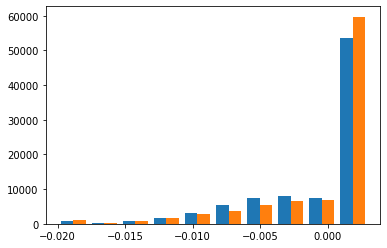

In [48]:
plt.hist(x)

In [49]:
np.mean(np.abs((df['close'] - df['open']).values))

0.0002680967377807882

In [20]:
dfSmall['label'] = getLabel(df, window_size=30, order=-1)

In [22]:
dfSmall.head()

,bin,datetime,open,high,low,close,volume,count,High-Low,Close-Low,...,KlineEnterDline14,DlineEnterKline24,KlineEnterDline24,DlineEnterKline36,KlineEnterDline36,DlineEnterKline48,KlineEnterDline48,DlineEnterKline100,KlineEnterDline100,label
0,"(2018, 1, 1, 102)",2018-01-01 17:00:00,1.20037,1.20100,1.20017,1.20094,0,10,0.00083,0.00077,...,False,False,False,False,False,False,False,False,False,-0.2
1,"(2018, 1, 1, 103)",2018-01-01 17:10:00,1.20094,1.20105,1.20036,1.20050,0,10,0.00069,0.00014,...,False,False,False,False,False,False,False,False,False,11.0
2,"(2018, 1, 1, 104)",2018-01-01 17:20:00,1.20053,1.20065,1.20042,1.20065,0,9,0.00023,0.00023,...,False,False,False,False,False,False,False,False,False,12.3
3,"(2018, 1, 1, 105)",2018-01-01 17:30:00,1.20064,1.20164,1.20063,1.20134,0,10,0.00101,0.00071,...,False,False,False,False,False,False,False,False,False,6.8
4,"(2018, 1, 1, 106)",2018-01-01 17:40:00,1.20131,1.20149,1.20131,1.20134,0,10,0.00018,0.00003,...,False,False,False,False,False,False,False,False,False,5.3


In [ ]:
high_rsi = df[(df['rsi14'] > (100-t))]
low_rsi = df[(df['rsi14'] < t)]

bins_range = np.linspace(-15.5, 15.5,11)
blue = plt.hist(low_rsi['label'], bins = bins_range, alpha = 0.8, density = True);
red = plt.hist(high_rsi['label'], bins = bins_range, alpha = 0.8, density = True);

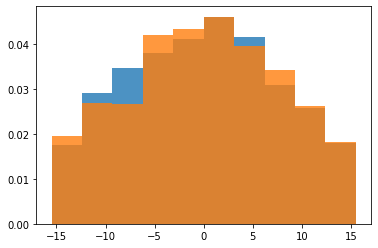

In [55]:
sell = dfSmall[dfSmall['DlineEnterOverSold24']]['label']
buy = dfSmall[dfSmall['DlineEnterOverBought24']]['label']
# low_rsi = df[(df['rsi14'] < t)]

bins_range = np.linspace(-15.5, 15.5,11)
blue = plt.hist(buy, bins = bins_range, alpha = 0.8, density = True);
red = plt.hist(sell, bins = bins_range, alpha = 0.8, density = True);

In [36]:
blue

(array([0.01945398, 0.02478512, 0.03167507, 0.03815973, 0.04158912,
        0.04648379, 0.04236852, 0.03357682, 0.02534629, 0.01914222]),
 array([-15.5, -12.4,  -9.3,  -6.2,  -3.1,   0. ,   3.1,   6.2,   9.3,
         12.4,  15.5]),
 <a list of 10 Patch objects>)

In [56]:
n = blue[0].shape[0]//2
d = list()
for i in range(n):
    d.append((blue[0][i] - red[0][i])*-np.mean([blue[1][i], blue[1][i+1]]))
for i in range(n):
    d.append((-blue[0][-(i+1)] + red[0][-(i+1)])*np.mean([blue[1][-(i+1)], blue[1][-(i+1)-1]]))

In [57]:
sum(d)

0.05777023291511375

In [31]:

severity = 
difference = np.abs(blue[0] - red[0])
np.sum(severity*difference)/20*100

0.23142432761839102

-5.661611374407499
-4.2216981132075935


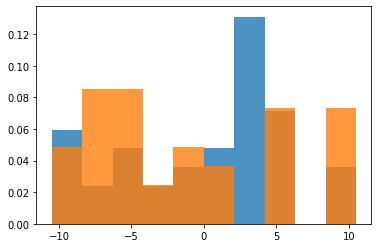

In [177]:
overcross = df[df['ma_sw'] == 1]
undercross = df[df['ma_sw'] == -1]

# bins_range = range(-20, 20, 1)
bins_range = np.linspace(-10.5, 10.5,11)
blue = plt.hist(overcross['label'], bins = bins_range, alpha = 0.8, density = True);
red = plt.hist(undercross['label'], bins = bins_range, alpha = 0.8, density = True);
# plt.hist(mode_rsi['label'], bins = bins_range, alpha = 0.2, density = True);
print(overcross['label'].mean())
print(undercross['label'].mean())

In [ ]:
severity = np.abs((blue[1][0:-1] + blue[1][1:])/2)
difference = np.abs(blue[0] - red[0])
np.sum(severity*difference)/20*100

In [ ]:
print(np.mean(label), len(label))

In [103]:
data = df[['rsi14', 'diff', 'label']]

KeyError: "['rsi14', 'label'] not in index"

In [ ]:
data.head()

In [56]:
data = df
x = data[['diff']].values
# label = data[['label']].values
label = y
split_point = int(len(x)*0.9)
x_t = x[0:split_point]
y_t = label[0:split_point]
x_v = x[split_point:]
y_v = label[split_point:]

In [58]:
print(type(x_t), type(y_t))
print(x_t.shape, y_t.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(79731, 1) (79731, 2)


In [60]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [94]:
t_gen = TimeseriesGenerator(data=x_t,targets=y_t, length=24*10, stride = 5, batch_size=2**8)
v_gen = TimeseriesGenerator(data=x_v,targets=y_v, length=24*10, stride = 5, batch_size=32)

In [95]:
t_gen.__len__()

63

In [96]:
from tensorflow.keras.layers import Dense, Input, Conv1D, Reshape, Flatten, LSTM, concatenate, Conv2D, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow as tf

In [97]:
inp = Input(shape=(24*10,1), dtype = tf.float32)
x = Reshape((24*10,1,1), dtype = tf.float32)(inp)
print(x.shape)
x = Conv2D(8*2, kernel_size  = (3, 1), strides = (2,1), dtype = tf.float32, activation = 'tanh')(x)
print(x.shape)
x = Conv2D(16*2, kernel_size = (3, 1), strides = (2,1), dtype = tf.float32, activation = 'tanh')(x)
print(x.shape)
x = Conv2D(32*2, kernel_size = (3, 1), strides = (2,1), dtype = tf.float32, activation = 'tanh')(x)
x = Conv2D(64*2, kernel_size = (3, 1), strides = (2,1), dtype = tf.float32, activation = 'tanh')(x)
print(x.shape)
# x = TimeDistributed(LS)
# x = AveragePooling2D()(x)
print(x.shape)
# x = LSTM(128, activation=None, return_sequences=True)(x)
# x = LSTM(32, activation=None, return_sequences=False)(x)
z = Flatten(dtype = tf.float32)(x)
print(z.shape)
# x = Dense(128, dtype = tf.float32)(z)
# x = Dense(64, dtype = tf.float32)(x)
# x = Dense(32, dtype = tf.float32)(x)
# x = Dense(8, dtype = tf.float32)(x)
# x = Dense(1, dtype = tf.float32, name = 'value')(x)


y = Dense(128, activation = 'relu', dtype = tf.float32)(z)
# y = Dense(64, dtype = tf.float32)(y)
# y = Dense(32, dtype = tf.float32)(y)
y = Dense(8, activation = 'relu', dtype = tf.float32)(y)
y = Dense(2, dtype = tf.float32, name='select')(y)
# v = concatenate([x,y])
print(y.shape)
model = Model(inputs = inp, outputs = y)

(None, 240, 1, 1)
(None, 119, 1, 16)
(None, 59, 1, 32)
(None, 14, 1, 128)
(None, 14, 1, 128)
(None, 1792)
(None, 2)


In [ ]:
# def mse_rev(y_true, y_pred):
#     value = y_pred[0]
#     select = y_pred[1]
#     return tf.reduce_sum((y_true - value)**2*select/tf.reduce_mean(y_pred[1]))

In [ ]:
def mse_rev(y_true, y_pred):
    w = y_pred[:,1] + 0.001
    l2 = tf.reduce_sum(tf.square(y_true - y_pred[:,0])*w)/tf.reduce_sum(w)
    return l2

In [98]:
model.compile(optimizer='adam', loss='mae')

In [99]:
model.fit(t_gen, validation_data=v_gen, epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 54 steps
Epoch 1/50
63/63 [==============================] - 2s 25ms/step - loss: 0.0237 - val_loss: 0.0038
Epoch 2/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 3/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 4/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 5/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 8/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 9/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 10/50
63/63

In [100]:
y_pred = model.predict(t_gen)

([array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 15899.]),
  array([15899.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.])],
 array([0.00292602, 0.00294494, 0.00296386, 0.00298278, 0.00300171,
        0.00302063, 0.00303955, 0.00305847, 0.0030774 , 0.00309632,
        0.00311524], dtype=float32),
 <a list of 2 Lists of Patches objects>)

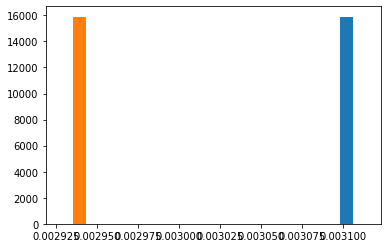

In [101]:
plt.hist(y_pred)

In [ ]:
t_gen = TimeseriesGenerator(data=x_t,targets=y_t, length=24*60, stride = 30, batch_size=2**6)

In [ ]:
for i in range(t_gen.__len__()):
    x = t_gen.__getitem__(i)
    pred = model(x[0])

    # pred
    print("---------------------------------")
    print(mse_rev(x[1], pred))
    
    print(mse(x[1], pred[:,0]))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
print(model.summary())

In [ ]:

y_valid = np.array([])
for i in range(v_gen.__len__()):
    chunk = v_gen.__getitem__(i)
#     print(chunk[1])
    y_valid = np.concatenate([y_valid, chunk[1]])

y_train = np.array([])
for i in range(t_gen.__len__()):
    chunk = t_gen.__getitem__(i)
    y_train = np.concatenate([y_train, chunk[1]])

print(mse(y_valid, np.mean(y_train)))

print(mse(y_train, np.mean(y_train)))

In [ ]:
def step(X, y):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = mse(y, pred)
    grads = tape.gradient(loss, model.trainable_variables)
    return grads

In [ ]:
INIT_LR = 1e-3
EPOCHS = 5
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [ ]:
EPOCHS = 20
total_steps = EPOCHS*t_gen.__len__()
steps_for_update = int(1/2*t_gen.__len__())
total_updates = total_steps//steps_for_update
counter = 0
cs = 0
for u in range(total_updates):
    for _ in tqdm(range(steps_for_update)):
        i = cs%t_gen.__len__()
        trainX, trainY = t_gen.__getitem__(i)
        if counter == 0:
            grads = step(trainX, trainY)
        else:
            new_grads = step(trainX, trainY)
            grads = [(grads[i]*counter + new_grads[i])/(counter+1) for i in range(len(grads))]
        counter += 1

        if counter == steps_for_update:
            opt.apply_gradients(zip(grads, model.trainable_variables))
            counter = 0
            print('Weights updated at step {} and epoch {}'.format(u, u//t_gen.__len__()));
            print('Model evaluated on valid data:', model.evaluate(v_gen));
            print('Model evaluated on train data:', model.evaluate(t_gen));
        cs += 1